## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Importing](#importing)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

[A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these.]

In this project, I will be analyzing the results of an A/B test run by an e-commerce website, with the goal of deciding if the company should implement the new page design, keep the old page, or perhaps run the experiment longer to make their decision.

First, to get a sense of the data at hand, we should check for cleanliness and tidiness.

<a id='importing'></a>
#### Importing



To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Taking a quick look:

In [92]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

Missing values:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values, great.

Looking at group and landing_page, it looks like we don't really need them both.  
Let's check them first, did they ever not match?

In [6]:
df.query('group == "treatment" and landing_page == "old_page"').shape[0]

1965

In [7]:
df.query('group == "control" and landing_page == "new_page"').shape[0]

1928

Those rows must have been incorrectly given, so I will remove every occurance where control and landing_page columns don't match.

In [93]:
#To drop them, first we get a query of the items that don't match, then we give its index to the drop function.
df.drop(df.query('group == "treatment" and landing_page != "new_page"').index,inplace=True)
df.drop(df.query('group == "control" and landing_page != "old_page"').index,inplace=True)
df.shape

(290585, 5)

Double Check all of the incorrect rows were removed

In [9]:
# this should be 0
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

In [95]:
# this should be 0
df[((df['group'] == 'control') == (df['landing_page'] == 'old_page')) == False].shape[0]

0

A great deal of rows were dropped.  
Now let's check for duplicates:

In [94]:
df.user_id.nunique()

290584

It seems that we have one duplicate row, let's examine it:

In [96]:
dup = df[df.duplicated(subset=['user_id'],keep=False)]
dup

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the rows:

In [97]:
df.drop(dup.index[0],inplace=True,axis=0)

Now I will remove one of the columns, group or landing_page.  
It's a matter of preference which one I choose, so I will go for group:

In [98]:
df.drop(columns=['group'],inplace=True)

In [99]:
df.head()

,user_id,timestamp,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,old_page,0
1,804228,2017-01-12 08:01:45.159739,old_page,0
2,661590,2017-01-11 16:55:06.154213,new_page,0
3,853541,2017-01-08 18:28:03.143765,new_page,0
4,864975,2017-01-21 01:52:26.210827,old_page,1


<a id='probability'></a>
#### Probabilities

Alright, now that we have our data clean and tidy, let's do some probabilities to know what to expect.

Probability of an individual converting regardless of the page they receive:

In [100]:
prop_convert = df.converted.mean()
prop_convert

0.11959708724499628

To see if it differs for each page, I will check the old_page users conversion rate:

In [101]:
old_mean = df.query('landing_page == "old_page"').converted.mean()
old_mean

0.1203863045004612

And for the new page:

In [102]:
new_mean = df.query('landing_page == "new_page"').converted.mean()
new_mean

0.11880806551510564

How many users are on the new page?

In [103]:
len(df.query('landing_page == "new_page"')) / df.shape[0]

0.5000619442226688

From that one could say that there isn't much of a difference between the old page and the new page conversion rate.  
Also, since there are almost as many users on new page as on the old page, the ratios computed show that we shouldn't expect the new page to be really better.  
But more testing is required.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

We found out before that it's reasonable to not expect much a difference between the pages performance.  
So going from that, we can assume that the new page has the same performance, or worse performance, than the old page _unless it proves otherwise_.  
Then, the **null** and **alternative** hypothesis would be as follows:  

$H0 : Pnew <= Pold$  
$H1 : Pnew > Pold$

**$p_{old}$** and **$p_{new}$**, are the converted rates for the old and new pages.


To start, I will assume that under the null hypothesis $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

Then to do the **A/B** Test, I will create a sampling distribution for the difference in **converted rate** between the two pages over 10,000 iterations of calculating an estimate from the null.

Defining the default convert rate $p_{new}$ and $p_{old}$:

In [104]:
p_new = p_old = prop_convert
p_new , p_old

(0.11959708724499628, 0.11959708724499628)

Defining the number of users on the new page:

In [105]:
n_new = df.query('landing_page == "new_page"').user_id.nunique()
n_new

145310

Defining the number of users on the old page:

In [106]:
n_old = df.query('landing_page == "old_page"').user_id.nunique()
n_old

145274

Now I will run some samples as required.

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.

In [107]:
new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null. 

In [108]:
old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Computing $p_{new}$ - $p_{old}$ for the simulated values

In [109]:
new_page_converted.mean() - old_page_converted.mean()

0.0013536767501305946

From that it seems that the new page in fact performed slightly worse than the old page, but this isn't enough as an evidence, we need to sample a distribution.

I will create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process above.

This can be done in two ways:
1. For loop 10000 times, while making a sample and calculating a random.choice for each sample.
2. Using the numpy random binomial function.

Both of them work but the second is much faster, at least 20x (for me)  
(I'm just providing the code of the for loop so that the reviewer can check my understanding)

In [56]:
p_diffs = np.zeros(10000)
for i in range(10000):
    
    _sample = df2.sample(df2.shape[0],replace=True)
    new_group = _sample.query('landing_page == "new_page"')
    conv_new = new_group.converted.mean()
    old_group = _sample.query('landing_page == "old_page"')
    conv_old = old_group.converted.mean()
    sample_p_new = np.random.choice([0,1],size=len(new_group),p=[1-p_new,p_new])
    sample_p_old = np.random.choice([0,1],size=len(old_group),p=[1-p_old,p_old])
    p_diffs[i] = sample_p_new.mean() - sample_p_old.mean()
    

In [110]:
p_diffs = []
#Using the binomial is an alternative to the for loop above , and it gives the same* results
#* (possibly slightly different results but at a very small significance level)

new_convert = np.random.binomial(n_new,p_new,10000)/n_new
old_convert = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_convert - old_convert
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00056233, -0.00024307,  0.00081675, ...,  0.00066546,
       -0.00199792, -0.00081417])

Plot a histogram of the **p_diffs**.

(array([   8.,   99.,  525., 1646., 2821., 2838., 1496.,  472.,   88.,
           7.]),
 array([-4.65497007e-03, -3.71753640e-03, -2.78010273e-03, -1.84266906e-03,
        -9.05235395e-04,  3.21982742e-05,  9.69631943e-04,  1.90706561e-03,
         2.84449928e-03,  3.78193295e-03,  4.71936662e-03]),
 <a list of 10 Patch objects>)

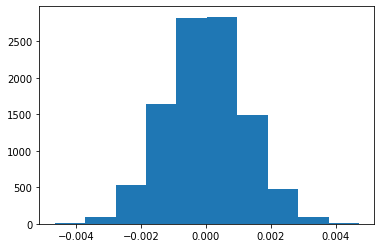

In [111]:
plt.hist(p_diffs)

I will plot the original difference found in the orignal data set, as a line on the plot:

(array([   8.,   99.,  525., 1646., 2821., 2838., 1496.,  472.,   88.,
           7.]),
 array([-4.65497007e-03, -3.71753640e-03, -2.78010273e-03, -1.84266906e-03,
        -9.05235395e-04,  3.21982742e-05,  9.69631943e-04,  1.90706561e-03,
         2.84449928e-03,  3.78193295e-03,  4.71936662e-03]),
 <a list of 10 Patch objects>)

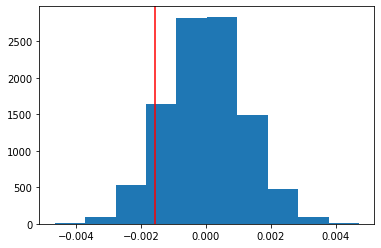

In [112]:
original_avg_diff = new_mean - old_mean

plt.axvline(x=original_avg_diff,color='red')
plt.hist(p_diffs)

Since our alternative hypothesis is greater than the mean, then it seems that most of our data is actually greater than it, so maybe we won't reject the null? Let's check.

Computing the proportion of the **p_diffs** are greater than the actual difference observed in the original data set:

In [113]:
original_avg_diff = new_mean - old_mean
(p_diffs > original_avg_diff).mean()

0.9024

As expected, the p-value is 0.9024, which is much greater than our error rate, 0.05.  
So we fail to reject the null.  
Which means that the new page design doesn't seem to offer an advantage.  
Actually, from the previous data, it's possible that it will hinder the performance of the conversion process.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

Here I will use statsmodels api to compute the p-value for our hypothesis tests.  
This is to make sure I didn't do any mistakes during my analysis.  
First let's initialize some data:

In [114]:
import statsmodels.api as sm

convert_old = df.query('landing_page == "old_page"').converted.sum()
convert_new = df.query('landing_page == "new_page"').converted.sum()

Now I will use `stats.proportions_ztest` to compute the test statistic and p-value.

In [115]:
from statsmodels.stats.proportion import proportions_ztest

stat, pval = proportions_ztest([convert_old,convert_new], [n_old,n_new],alternative = 'smaller')
stat, pval = proportions_ztest([convert_new,convert_old], [n_new,n_old],alternative = 'larger')

stat,pval

(-1.3109241984234394, 0.9050583127590245)

Great, the p-value is almost the same.  
(That small difference could be because I used the binomial function, maybe using the for loop could have been more accurate, but this doesn't matter.)

Looking at a z-score table, I can confirm that the z-score given corresponds to the same p-value calculated.  
The -1.31.. corresponds to 0.0951.  
Because that z-score gives us the area (or p-value) for the left, we should subtract it from 1 to get  
0.905.  
Which is the required.  

**All in all, this means that based on this test as well, the company shouldn't go for the new page, yet.**

<a id='regression'></a>
### Part III - A regression approach


Now I will do a logistic regression to be more confident in the results

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

I will use statsmodels as required to make the logistic regression model.  
First, we need an intercept column.  
Second, we need a dummy column in place of the landing_page column.  

So let's make those first

In [116]:
df['intercept'] = 1
#Get the dummies. This returns two columns
dummies = pd.get_dummies(df['landing_page'])
#Get only one of the two columns
df['ab_page'] = dummies.iloc[:,0]
df.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [117]:
log_ml = sm.Logit(df['converted'],df[['intercept','ab_page']])
results = log_ml.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [118]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Feb 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:04:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value here for the ab_page is 0.19.  
While smaller than the p-value we got from our hypothesis test, it still gives us the same conclusion.

However, the reason it's different is because our null and alternative hypotheses when using logistic regression are as follows:

$Ho: P_{new} - P_{old}  = 0$  
$H1: P_{new} - P_{old}  \neq 0$

So it's a two tailed test, regardless of whether the new page performs better or worse, what matters here is that it performed in a notably different way.    
But our original hypothesis test was a one tailed test: Greater than only.  
From that we can also note that it's more likely that there is a difference in the performance of the two pages than that the new page performed better, albiet both probabilities are small and neglibible.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There are certainly other things that affect whether an individual would convert or not:
1. The time spent on the page
2. Number of general clicks or views (i.e. how many items had the individual viewed inside the page?)
3. Interest in the affair. Uninterested individuals won't convert either way.

But there are some drawbacks, most notably:
1. Having many terms/features would make it harder to understand the results/conclusions
2. We might be more prone to overfitting our data
3. Sometimes new terms don't add much to the accuracy of our model, so they may not be very much useful


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [119]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [120]:
df_m =  df.merge(countries,on=['user_id'],how='inner')
df_m.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,US


In [121]:
countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [122]:
#We have three countries:
dummies = pd.get_dummies(df_m['country'])

#Here, if both CA and UK are 0, it means the country is US
df_m[['CA','UK']] = dummies.iloc[:,0:2]

df_m.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,US,0,0


In [123]:
log_ml_c = sm.Logit(df_m['converted'],df_m[['intercept','ab_page','CA','UK']])
results = log_ml_c.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 20 Feb 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:04:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Calculating the coefficeints:

In [98]:
np.exp(0.0099),np.exp(-0.0408)

(1.0099491671175422, 0.9600211149716509)

We can say that if the individual is from the UK, then it's 1.009 more likely that they would convert than if they were from the US.
Similarly, if the individual is from CA, it's 0.96 more likely that would would convert than if they were from the US, in other words, they are:

In [124]:
np.exp(0.0408) # = 1/exp(-0.0408)

1.0416437559600236

1.041 less likely to convert than if they were from the US.

Are these figures significant? They aren't, in my opinion.

Also, looking at the p-values of each, they don't seem to contribue much.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

To see more closely how each country affects the conversion, I will make a column for the interaction between ab_page and CA, and another column for the interaction between ab_page and UK:

In [125]:
df_m['ab_page_CA'] = df_m['ab_page'] * df_m['CA']
df_m['ab_page_UK'] = df_m['ab_page'] * df_m['UK']
df_m.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,country,CA,UK,ab_page_CA,ab_page_UK
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,US,0,0,0,0


In [126]:
log_interaction = sm.Logit(df_m['converted'],df_m[['intercept','ab_page','CA','UK','ab_page_CA','ab_page_UK']])
results = log_interaction.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Feb 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:04:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

To interpret the coefficients, I can write the logistic regression equation:  
$LogP(Y=1) = B0 + B1_{page} + B2_{CA} + B3_{UK} + B4_{page * CA} + B5_{ab_page * UK}$  

Assuming individual is canadian, B3 and B5 will be zero, so:  
$LogP(Y=1) = B0 + B1_{page} + B2_{CA} + B4_{page * {CA}}$  

I can rewrite it as:  
$LogP(Y=1) = B0 + [B1 + B4_{CA}]_{page} + B2_{CA}$  

Then, B1 + B4_CA is the conersion odds ratio for new page vs old page.   
And B2 is conversion odds ration for canadians vs non canadians.  

So B4 is the difference between conversion odds ratio for canadians vs non canadians and conversion odds for individuals on the new page vs old page.
Same can be done to see that B5 is the difference between conversion odds ratio for UK vs non canadians and conversion odds for individuals on the new page vs old page.

B4 = -0.0469 and B5 =  0.0314  
Calculating the coefficients:

In [46]:
np.exp(-0.0469),np.exp(0.0314)

(0.9541828111007262, 1.0318981806179213)

It turns out the interaction doesn't make much of an effect.  
Since the values I got from exponentiation are quite close to 1, which in turns means that the difference in conversion odds are negligible.

### Bonus: Adding a time feature

I would like to see if the timestamp of the page view does affect the conversion.
I will use logistic regression here.

First, I need to convert string date to datetime object:

In [127]:
df_m.timestamp = pd.to_datetime(df_m.timestamp)
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 11 columns):
user_id         290584 non-null int64
timestamp       290584 non-null datetime64[ns]
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
CA              290584 non-null uint8
UK              290584 non-null uint8
ab_page_CA      290584 non-null uint8
ab_page_UK      290584 non-null uint8
dtypes: datetime64[ns](1), int64(3), object(2), uint8(5)
memory usage: 16.9+ MB


Now I will partition entries into four categories:  
1. after mid night: from 0 till 6   
2. morning: from 6 till 12  
3. after noon: from 12 till 18  
4. night: from 18 till 24  

In [128]:
#First I will add a column that has 0 for hours less than 6, 1 for hours between 6 and 12, 2 for hours 12-18, and 3 for 18-24
#The remainder and division functions do the math for us
df_m['period'] = (df_m['timestamp'].dt.hour % 24) // 6  
#Give each number a name that represents it
df_m['period'].replace({0:'mid_night',1:'morning',2:'afternoon',3:'night'},inplace=True)
df_m.head()          

,user_id,timestamp,landing_page,converted,intercept,ab_page,country,CA,UK,ab_page_CA,ab_page_UK,period
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,US,0,0,0,0,night
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,US,0,0,0,0,morning
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US,0,0,0,0,afternoon
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US,0,0,0,0,night
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,US,0,0,0,0,mid_night


In [129]:
#Now make a new dummy column for each period using get_dummies
periods_dummies = pd.get_dummies(df_m['period'])
df_m[['afternoon','mid_night','morning','night']] = periods_dummies
df_m.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,country,CA,UK,ab_page_CA,ab_page_UK,period,afternoon,mid_night,morning,night
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,US,0,0,0,0,night,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,US,0,0,0,0,morning,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US,0,0,0,0,afternoon,1,0,0,0
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US,0,0,0,0,night,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,US,0,0,0,0,mid_night,0,1,0,0


Let me see first how does the time affect the conversion directly, along with the page. I will use morning as a base.

In [130]:
log_md_time = sm.Logit(df_m['converted'],df_m[['intercept','ab_page','afternoon','night','mid_night']])
results = log_md_time.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366100
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 20 Feb 2020   Pseudo R-squ.:               5.793e-05
Time:                        19:05:15   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01509
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9804      0.013   -155.568      0.000      -2.005      -1.955
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
afternoon      0.0007      0.016      0.043      0.966      -0.031       0.032
night          0.0060      0.016      0.373      0.709      -0.026       0.038
mid_night     -0.0407      0.016     -2.502      0.012      -0.073      -0.009
==============================================================================
"""

Interestengly, it seems that mid_night period is less likely to have conversions than the morning period.  
Because it's coefficient is negative, which means if we take the positive like so:

In [87]:
np.exp(0.0407)

1.0415395967924728

it's 1.04 less likely that a conversion takes place if it were in mid night than in morning.  
Other periods don't affect the conversion much compared to morning since their coefficient is small.  

Also, looking at p-values, mid_night has one at 0.012 which means it does have an effect on converting..  
while other periods don't affect much, again compared to morning.  
**All in all**, it seems that _conversion takes place mostly on morning, afternoon, and night_ periods.  
Which makes sense.

Let's see if this will change when incorporating the countries;

In [131]:
log_md_time = sm.Logit(df_m['converted'],df_m[['intercept','ab_page','CA','UK','afternoon','night','mid_night']])
results = log_md_time.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366095
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Thu, 20 Feb 2020   Pseudo R-squ.:               7.312e-05
Time:                        19:06:02   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01633
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9809      0.013   -149.186      0.000      -2.007      -1.955
ab_page       -0.0149      0.011     -1.303      0.193      -0.037       0.008
CA            -0.0408      0.027     -1.516      0.129      -0.093       0.012
UK             0.0099      0.013      0.748      0.455      -0.016       0.036
afternoon      0.0006      0.016      0.036      0.971      -0.031       0.032
night          0.0060      0.016      0.371      0.711      -0.026       0.038
mid_night     -0.0407      0.016     -2.506      0.012      -0.073      -0.009
==============================================================================
"""

We got almost the exact coef. we got before for the time periods.  
And we got a very similar coef. for CA and UK compared to our first model with countries.  
What this means is that there isn't much of a correlation between time periods and countries.  
That may be because each timestamp was registered at the local time of the individual.  

<a id='conclusions'></a>
## Finishing Up

The testing methods performed here are a strong evidence that the new page didn't offer much of an advantage over the old page.  
Running the experiment longer may be helpful, but since almost no difference between the two pages have been seen, I suspect that dropping that new page design for another one, or perhaps keeping the same old page, would both be wiser choices

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [133]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

# Resources

Logistic regression interaction interpretation

http://www.cantab.net/users/filimon/cursoFCDEF/will/logistic_interact.pdf

Answers here helped me:

https://stackoverflow.com/questions/55571311/get-part-of-day-morning-afternoon-evening-night-in-python-dataframe

https://stackoverflow.com/questions/32204631/how-to-convert-string-to-datetime-format-in-pandas-python